In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [52]:
# circuit constants
Co = 1e-15 # 1 fF
Vo = 1 # 1 V reset
Qo = Co * Vo
No = Qo / 1.602e-19

# graph time scale, to us
Tf = 150
Iscale = 1e-9 # nA = 1 fC / us
Qscale = Iscale * 1e-6
MinResetTime = 1 / 30 # single clock cycle of Digital ASIC in us
times = np.arange(0, Tf, MinResetTime)
IMax = Qo / MinResetTime 

# function building for input charge
fnc = lambda x: 2 * np.cos(4*2*np.pi*x/Tf) + 2
fnc = lambda x: 2 * np.exp(-1*x/Tf)
fnc = lambda x: 2 * np.exp(x/Tf)
fnc = lambda x: 1 # constant amp input scaled to nA
fnc = lambda x: 2 * np.sin(4*2*np.pi*x/Tf) + 2

def inter(fnc, a, b):
    """
    integrate the current
    """
    return integrate.quad(fnc, a, b)[0]
def makeInput(f=fnc, times=times):
    x = [f(t) for t in times]
    y = [inter(fnc, 0, t) for t in times]
    return x, y

x,y = makeInput()

charge = [j * Qscale for j in y]
voltage = [q / Co for q in charge]

print(f"Running with Current Max: {IMax / Qscale:1.2f} nA")
print(f"Reset electrons: {No:1.2f}, Charge: {Qo*1e15:2.1f} fC")
print(f"Min Reset Time: {MinResetTime:2.3f} us")

Running with Current Max: 30.00 nA
Reset electrons: 6242.20, Charge: 1.0 fC
Min Reset Time: 0.033 us


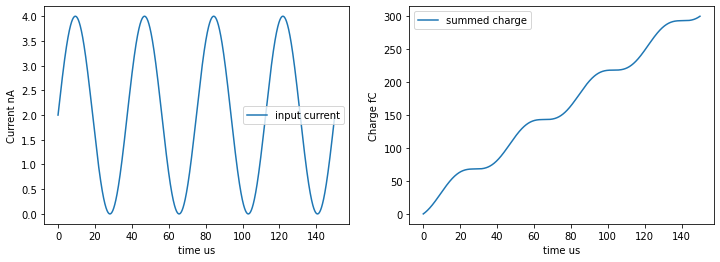

In [53]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(times, x, label="input current")
axs[0].set_xlabel("time us")
axs[0].set_ylabel("Current nA")
axs[0].legend()
axs[1].plot(times, y, label="summed charge")
axs[1].set_xlabel("time us")
axs[1].set_ylabel("Charge fC")
axs[1].legend()

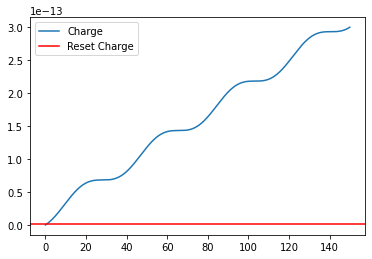

In [54]:
# make the appropriate unite conversions here to nA
plt.plot(times, charge, label="Charge")
plt.axhline(y=Qo, c='r', label="Reset Charge")
plt.legend()

In [55]:
def countResets(times, chargeInput):
    """
    Take as input times and charge value across the capacitor
    create a series of resets to estimate the charge

    also takes as input the Qo which is the amount of resets required to happen
    for this function

    returns:
        resets - 1-d array indicating the reset time
    """
    assert len(times) == len(chargeInput), "error not a time for every charge"

    Qout = chargeInput[0]
    To = -1
    resets = []
    max_resets = []

    # times should be the minimum clk cycle observed at the FPGA
    for i, (t, q) in enumerate(zip(times, chargeInput)):
        # check to make sure that we're not ahead in resets
        if To < t:
            To = t
        elif(q >= Qout + Qo): # broken time!
            max_resets.append(i)

        # empty charge out on cap if it's stored an extra Qo
        while(q >= Qout + Qo):
            resets.append(To)
            To += MinResetTime
            Qout += Qo

    if len(max_resets) > 0:
        print(f"warning exceeded max reset rate at index: {len(max_resets)}!")
    
    return resets

# create the data that the digital ASIC sees
Rs = countResets(times, charge)
Rtd = [Rs[i] - Rs[i-1] for i in range(1,len(Rs))]
print("expected resets:", int(max(charge)/Qscale))
print("received resets:", len(Rs))

expected resets: 299
received resets: 299


In [56]:
# view of the reset distribution over the time window
# f = plt.hist(Rtd, bins=100)
# f2 = plt.hist(Rs, bins=100, color="orange")

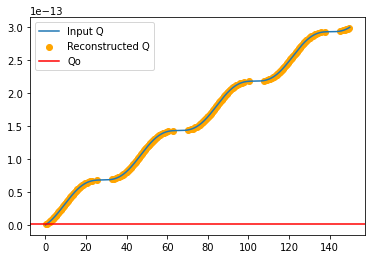

In [57]:
# reconstruct the Q here
Qsum = charge[0]
Qr = []
Qt = []
for r in Rs: 
    Qsum += Qo
    Qr.append(Qsum)
    Qt.append(r)

# reconstruct the current by taking the derivative of the CDF
plt.plot(times, charge, label="Input Q")
plt.scatter(Qt, Qr, label="Reconstructed Q", color="orange")
plt.axhline(y=Qo, c='r', label="Qo")
plt.legend()

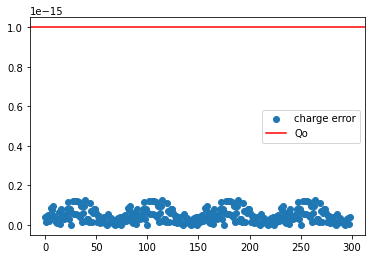

In [58]:
rmin = [np.absolute(times-r_t).argmin() for r_t in Rs]
err = [charge[r_t] - q_r for (r_t, q_r) in zip(rmin, Qr)]
plt.scatter(list(range(len(err))), err, label="charge error")
plt.axhline(y=Qo, c='r', label="Qo")
plt.legend()

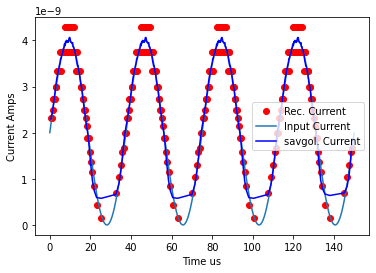

In [59]:
# reconstruct original current
from numpy import diff

dQ = diff(Qr)
dT = diff(Qt)
Ir = dQ/dT * 1e6
plt.scatter(Qt[:-1], Ir, label="Rec. Current", color="r")
Iin = [i * Iscale for i in x]
plt.plot(times, Iin, label="Input Current")

maxI = Qo / MinResetTime * 1e6
brokeIndex = 0
for i, j in enumerate(Ir): 
    if j > maxI*0.9:
        brokeIndex = i
        break
if brokeIndex:
    print("found max at index:", brokeIndex)
    minT = min(dT)
    # plt.axhline(y=maxI, c='orange', label="maxI")

# need to smooth around this point!
from scipy.signal import savgol_filter
if len(Ir) > 1:
    Ihat = savgol_filter(Ir, int(np.sqrt(len(Ir))), 4 if 4 < len(Ir) else 1)
    plt.plot(Qt[:-1], Ihat, label="savgol. Current", color="b")
    plt.xlabel("Time us")
    plt.ylabel("Current Amps")

plt.legend()

In [60]:
from scipy.fft import fft
Ifft =  fft(Qt)
print(len(Ifft))

299
